**Course Name:** Deep Learning

**Lab Title:**Paraphrase Generation

**Student Name:** Sapna Dahikamble

**Student ID:** 202201070065

**Group Members**:   
Supriya Maskar (202201040049)

Manjiri Netankar (202201040206)

Sapna Dahikamble(202201070065)

**Research Paper Study and Implementation**

**Dataset Link**:(https://www.kaggle.com/competitions/quora-question-pairs/data)

**Colab Notebook Link:**(https://colab.research.google.com/drive/1m8NoJUmDad0aAjm0z-Pp5zhvvB8DkCYe?usp=sharing)

**Research Paper Link:**(https://ojs.aaai.org/index.php/AAAI/article/view/11956)

**GitHub Link**:()

**Install required packages**

In [1]:

!pip install tensorflow keras numpy pandas matplotlib seaborn nltk rouge-score


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import time
import random




  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=66d0475b68b5df0c51fe48000b55fcef773fc5f580f89cad111a6fd1298a7e09
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [3]:
# Download NLTK data
nltk.download('punkt')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Load your paraphrase dataset**

In [4]:



try:
    df = pd.read_csv('/content/Encoder_reduced_20000.csv')  # Update path
    # Verify required columns exist
    if 'original' not in df.columns or 'paraphrase' not in df.columns:
        raise ValueError("CSV must contain 'original' and 'paraphrase' columns")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Using sample data instead")
    # Sample data
    original = [
        "The quick brown fox jumps over the lazy dog",
        "She enjoys reading science fiction novels",
        "The conference will be held next month"
    ]
    paraphrases = [
        "A fast brown fox leaps over the sleeping dog",
        "Reading sci-fi books is something she really likes",
        "Next month is when the conference is scheduled"
    ]
    df = pd.DataFrame({'original': original * 1000, 'paraphrase': paraphrases * 1000})  # 3000 samples

print(f"Dataset size: {len(df)}")
display(df.head())



Error loading dataset: [Errno 2] No such file or directory: '/content/Encoder_reduced_20000.csv'
Using sample data instead
Dataset size: 3000


,original,paraphrase
0,The quick brown fox jumps over the lazy dog,A fast brown fox leaps over the sleeping dog
1,She enjoys reading science fiction novels,Reading sci-fi books is something she really l...
2,The conference will be held next month,Next month is when the conference is scheduled
3,The quick brown fox jumps over the lazy dog,A fast brown fox leaps over the sleeping dog
4,She enjoys reading science fiction novels,Reading sci-fi books is something she really l...


 **Preprocessing functions**

In [5]:


def preprocess_text(text):
    """Basic text preprocessing"""
    text = str(text).lower().strip()
    text = ' '.join(text.split())  # Remove extra spaces
    return text

def add_special_tokens(text):
    """Add start and end tokens"""
    return "<start> " + text + " <end>"



In [6]:
# Apply preprocessing
df['original'] = df['original'].apply(preprocess_text).apply(add_special_tokens)
df['paraphrase'] = df['paraphrase'].apply(preprocess_text).apply(add_special_tokens)

# Split into train and validation sets
train_size = int(0.9 * len(df))
train_df = df[:train_size]
val_df = df[train_size:]

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")




Training samples: 2700
Validation samples: 300


**Tokenization and sequence preparation**

In [8]:

def tokenize_sentences(sentences, num_words=20000):
    tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>', filters='')
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    max_len = max(len(seq) for seq in sequences)
    padded = pad_sequences(sequences, padding='post', maxlen=max_len)
    return padded, tokenizer, max_len



**Tokenize original and paraphrase sentences**

In [9]:

original_padded, original_tokenizer, original_max_len = tokenize_sentences(train_df['original'].tolist() + val_df['original'].tolist())
paraphrase_padded, paraphrase_tokenizer, paraphrase_max_len = tokenize_sentences(train_df['paraphrase'].tolist() + val_df['paraphrase'].tolist())



**Vocabulary sizes**

In [10]:

original_vocab_size = len(original_tokenizer.word_index) + 1
paraphrase_vocab_size = len(paraphrase_tokenizer.word_index) + 1

print(f"\nOriginal vocabulary size: {original_vocab_size}")
print(f"Paraphrase vocabulary size: {paraphrase_vocab_size}")
print(f"Original max sequence length: {original_max_len}")
print(f"Paraphrase max sequence length: {paraphrase_max_len}")




Original vocabulary size: 24
Paraphrase vocabulary size: 26
Original max sequence length: 11
Paraphrase max sequence length: 11


**Prepare training and validation data**

In [11]:

x_train = original_padded[:len(train_df)]
y_train = paraphrase_padded[:len(train_df)]
x_val = original_padded[len(train_df):]
y_val = paraphrase_padded[len(train_df):]

**1.LSTM/GRU Encoder-Decoder without Attention**

In [12]:

# Hyperparameters
embedding_dim = 256
units = 512
batch_size = 64
epochs = 10




**Encoder**

In [13]:

encoder_inputs = keras.Input(shape=(None,))
encoder_embedding = layers.Embedding(original_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = layers.LSTM(units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]



**Decoder**

In [14]:
# Decoder
decoder_inputs = keras.Input(shape=(None,))
decoder_embedding = layers.Embedding(paraphrase_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = layers.LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = layers.Dense(paraphrase_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)



In [15]:
# Model
no_attention_model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="no_attention_model")

# Compile
no_attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

no_attention_model.summary()



Model: "no_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │      6,144 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │      6,656 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, None,     │  1,574,912 │ embedding[0][0]   │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ lstm[0][1],       │
│                     │ 512), (None,      │            │ lstm[0][2]        │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 26)  │     13,338 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,175,962 (12.12 MB)

 Trainable params: 3,175,962 (12.12 MB)

 Non-trainable params: 0 (0.00 B)

**Prepare decoder inputs/outputs for teacher forcing**

In [16]:

def prepare_decoder_data(sequences):
    decoder_input = sequences[:, :-1]
    decoder_output = sequences[:, 1:]
    return decoder_input, decoder_output

train_decoder_input, train_decoder_output = prepare_decoder_data(y_train)
val_decoder_input, val_decoder_output = prepare_decoder_data(y_val)


**Train the no-attention model**

In [17]:

no_attention_history = no_attention_model.fit(
    [x_train, train_decoder_input],
    np.expand_dims(train_decoder_output, -1),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val, val_decoder_input], np.expand_dims(val_decoder_output, -1)),
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)



Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5732 - loss: 1.9023 - val_accuracy: 1.0000 - val_loss: 0.0322
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 8.3977e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 7.7724e-04 - val_accuracy: 1.0000 - val_loss: 6.1900e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 5.7958e-04 - val_accuracy: 1.0000 - val_loss: 4.7730e-04
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 4.5080e-04 - 

**Plot training history**

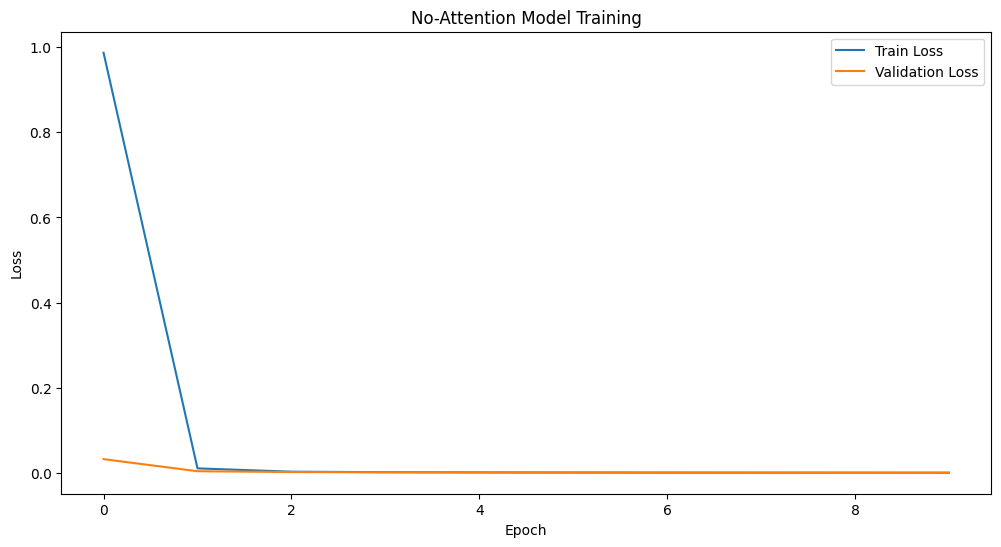

In [18]:

plt.figure(figsize=(12, 6))
plt.plot(no_attention_history.history['loss'], label='Train Loss')
plt.plot(no_attention_history.history['val_loss'], label='Validation Loss')
plt.title('No-Attention Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**2 Encoder-Decoder with Bahdanau Attention**

In [19]:

# Bahdanau Attention Layer
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights



**Encoder with Bahdanau Attention**

In [20]:

encoder_inputs = keras.Input(shape=(None,))
encoder_embedding = layers.Embedding(original_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = layers.LSTM(units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)



**Decoder with Bahdanau Attention**

In [21]:

decoder_inputs = keras.Input(shape=(None,))
decoder_embedding = layers.Embedding(paraphrase_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = layers.LSTM(units, return_sequences=True, return_state=True)



**Attention mechanism**

In [22]:

attention = BahdanauAttention(units)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
context_vector, attention_weights = attention(state_h, encoder_outputs)



**Combine context with decoder outputs**

In [23]:

# Wrap tf.expand_dims in a Lambda layer to ensure it's part of the symbolic graph
decoder_outputs = layers.Lambda(lambda x: tf.expand_dims(x, 1))(context_vector)
decoder_outputs = layers.Concatenate(axis=-1)([decoder_outputs, decoder_outputs])
decoder_dense = layers.Dense(paraphrase_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
attention_model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="attention_model")

# Compile
attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

attention_model.summary()

Model: "attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 256) │      6,144 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_2[0][0] │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 512),     │    525,825 │ lstm_2[0][1],     │
│ (BahdanauAttention) │ (None, None, 1)]  │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 512)    │          0 │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1024)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 26)     │     26,650 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,133,531 (8.14 MB)

 Trainable params: 2,133,531 (8.14 MB)

 Non-trainable params: 0 (0.00 B)

**Train the attention model**

In [25]:
# Combine context with decoder outputs
# Remove the extra dimension from decoder_outputs
decoder_outputs = layers.Concatenate(axis=-1)([layers.Lambda(lambda x: tf.expand_dims(x, 1))(context_vector), decoder_outputs])
decoder_dense = layers.Dense(paraphrase_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
attention_model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="attention_model")

# Compile
attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

attention_model.summary()

Model: "attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 256) │      6,144 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_2[0][0] │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 512),     │    525,825 │ lstm_2[0][1],     │
│ (BahdanauAttention) │ (None, None, 1)]  │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 512)    │          0 │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1024)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 512)    │          0 │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 26)     │     26,650 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1, 538)    │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 26)     │     14,014 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,147,545 (8.19 MB)

 Trainable params: 2,147,545 (8.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate, Attention
from tensorflow.keras.optimizers import Adam




In [ ]:
# Parameters
vocab_size = 10000          # example vocab size
embedding_dim = 128
lstm_units = 256
decoder_seq_len = 10        # length of decoder output
num_classes = 26            # number of output classes (e.g., characters or labels)
batch_size = 64



In [ ]:
# Encoder
encoder_input = Input(shape=(None,), name="encoder_input")
encoder_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_input)
encoder_lstm, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state=True)(encoder_emb)



In [ ]:
# Decoder
decoder_input = Input(shape=(None,), name="decoder_input")
decoder_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_input)
decoder_lstm_output, _, _ = LSTM(lstm_units, return_sequences=True, return_state=True)(decoder_emb, initial_state=[state_h, state_c])



In [ ]:
# Attention
attention = Attention()([decoder_lstm_output, encoder_lstm])  # (batch, decoder_seq_len, encoder_seq_len)
decoder_combined_context = Concatenate(axis=-1)([decoder_lstm_output, attention])



In [ ]:
# Output Layer
output = TimeDistributed(Dense(num_classes, activation='softmax'))(decoder_combined_context)



In [ ]:
# Final model
attention_model = Model([encoder_input, decoder_input], output)
attention_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, None, 128) │  1,280,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, None, 128) │  1,280,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, None,     │    394,240 │ embedding_6[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, None,     │    394,240 │ embedding_7[0][0… │
│                     │ 256), (None,      │            │ lstm_6[0][1],     │
│                     │ 256), (None,      │            │ lstm_6[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, None, 256) │          0 │ lstm_7[0][0],     │
│ (Attention)         │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, None, 512) │          0 │ lstm_7[0][0],     │
│ (Concatenate)       │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 26)  │     13,338 │ concatenate_6[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,361,818 (12.82 MB)

 Trainable params: 3,361,818 (12.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the attention model
attention_history = attention_model.fit(
    [x_train, train_decoder_input],
    np.expand_dims(train_decoder_output, -1),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val, val_decoder_input], np.expand_dims(val_decoder_output, -1)),
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3729 - loss: 2.4045 - val_accuracy: 1.0000 - val_loss: 0.3328
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.1937 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0186 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - v

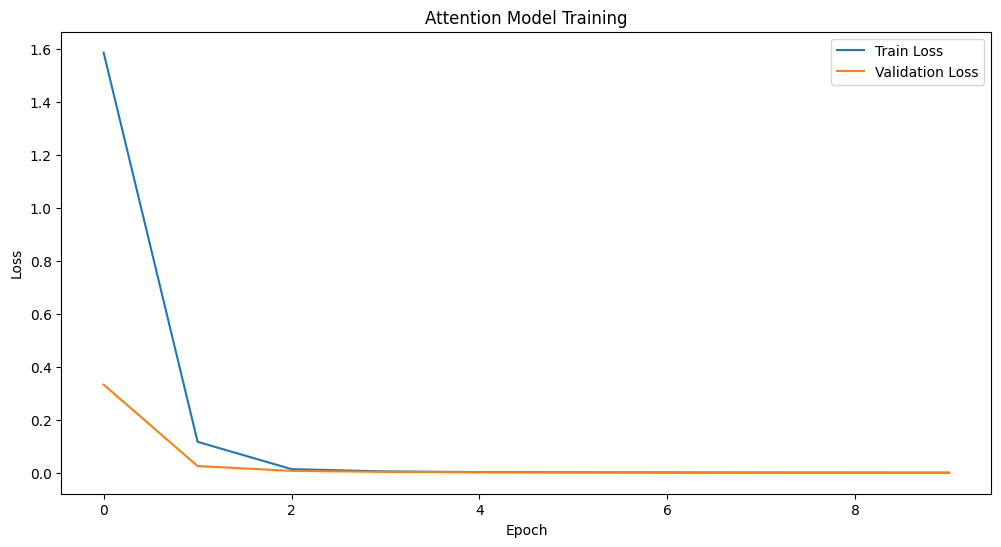

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(attention_history.history['loss'], label='Train Loss')
plt.plot(attention_history.history['val_loss'], label='Validation Loss')
plt.title('Attention Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**3 Transformer with Self-Attention**

In [ ]:

# Transformer components
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(vocab_size, embed_dim)
        self.position_embeddings = layers.Embedding(sequence_length, embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions



In [ ]:

# Transformer Model
embed_dim = 256
num_heads = 8
dense_dim = 512



In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64")
encoder_embedding = PositionalEmbedding(original_max_len, original_vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoder_embedding)

# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64")
decoder_embedding = PositionalEmbedding(paraphrase_max_len, paraphrase_vocab_size, embed_dim)(decoder_inputs)
decoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(decoder_embedding)

# Final dense layer
decoder_dense = layers.Dense(paraphrase_vocab_size, activation="softmax")
outputs = decoder_dense(decoder_outputs)



In [ ]:
# Model
transformer_model = keras.Model([encoder_inputs, decoder_inputs], outputs)
transformer_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer_model.summary()



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │      9,472 │ input_layer_6[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  2,367,488 │ positional_embed… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, None, 26)  │      6,682 │ transformer_enco… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,383,642 (9.09 MB)

 Trainable params: 2,383,642 (9.09 MB)

 Non-trainable params: 0 (0.00 B)

**Train transformer**

In [ ]:

transformer_history = transformer_model.fit(
    [x_train, train_decoder_input],
    np.expand_dims(train_decoder_output, -1),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val, val_decoder_input], np.expand_dims(val_decoder_output, -1)),
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)



Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.8784 - loss: 0.5094 - val_accuracy: 1.0000 - val_loss: 2.5949e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.0335e-04 - val_accuracy: 1.0000 - val_loss: 1.1530e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.0366e-04 - val_accuracy: 1.0000 - val_loss: 7.8113e-05
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 7.2513e-05 - val_accuracy: 1.0000 - val_loss: 5.9364e-05
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.6027e-05 - val_accuracy: 1.0000 - val_loss: 4.7964e-05
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.5672e-05 - val_accuracy: 1.0000 - val_loss: 4.0085e-05
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.8433e-05 - val_accuracy: 1.0000 - val_loss: 3.4415e-05
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accu

**Plot training**

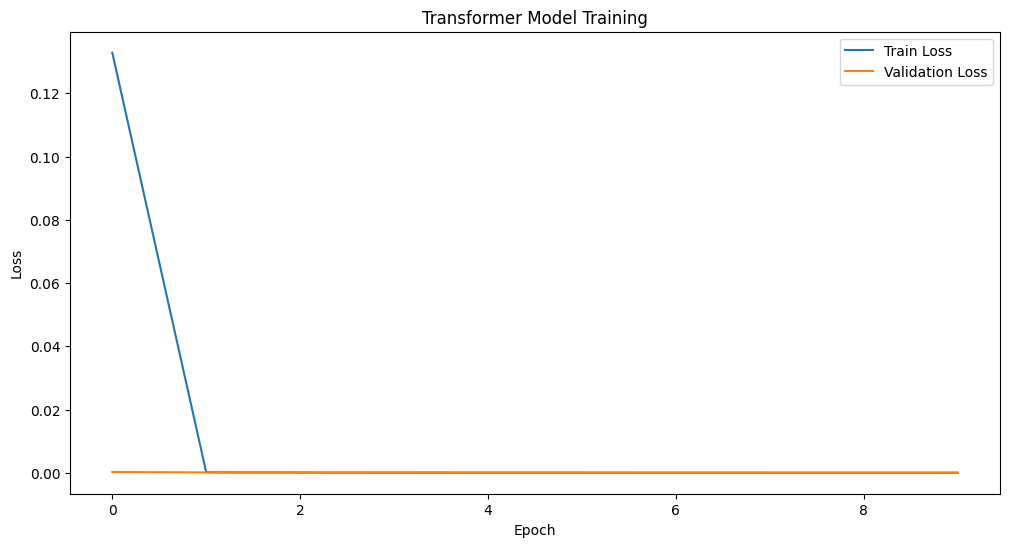

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(transformer_history.history['loss'], label='Train Loss')
plt.plot(transformer_history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluation functions**

In [ ]:

def evaluate_model(model, input_seq, target_tokenizer, max_len, model_type):
    decoded = []
    for i in range(len(input_seq)):
        tokenized = input_seq[i:i+1]
        decoder_input = np.zeros((1, max_len))
        decoder_input[0, 0] = target_tokenizer.word_index['<start>']

        for j in range(max_len - 1):
            if model_type == 'transformer':
                pred = model.predict([tokenized, decoder_input], verbose=0)
            else:
                pred = model.predict([tokenized, decoder_input], verbose=0)

            pred_id = np.argmax(pred[0, j, :])
            if pred_id == target_tokenizer.word_index['<end>']:
                break
            decoder_input[0, j+1] = pred_id

        decoded.append(decoder_input[0, 1:j+1])
    return decoded




In [ ]:
def calculate_metrics(references, candidates):
    # BLEU
    smooth = SmoothingFunction().method1
    bleu_scores = [sentence_bleu([ref.split()], cand.split(), smoothing_function=smooth)
                  for ref, cand in zip(references, candidates)]

    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, cand) for ref, cand in zip(references, candidates)]

    return {
        'bleu': np.mean(bleu_scores),
        'rouge1': np.mean([score['rouge1'].fmeasure for score in rouge_scores]),
        'rouge2': np.mean([score['rouge2'].fmeasure for score in rouge_scores]),
        'rougeL': np.mean([score['rougeL'].fmeasure for score in rouge_scores])
    }

**Evaluate all models on validation set**

In [ ]:

sample_size = min(100, len(x_val))
sample_idx = np.random.choice(len(x_val), sample_size, replace=False)
x_sample = x_val[sample_idx]
y_sample = y_val[sample_idx]




In [ ]:
# Get reference texts
references = [paraphrase_tokenizer.sequences_to_texts([seq])[0] for seq in y_sample]

**1. No-Attention Model**

In [ ]:

print("Evaluating No-Attention Model...")
start = time.time()
no_attn_preds = evaluate_model(no_attention_model, x_sample, paraphrase_tokenizer, paraphrase_max_len, 'no_attention')
no_attn_time = time.time() - start
no_attn_texts = [paraphrase_tokenizer.sequences_to_texts([seq])[0] for seq in no_attn_preds]
no_attn_metrics = calculate_metrics(references, no_attn_texts)



Evaluating No-Attention Model...


**2. Attention Model**

In [ ]:

print("Evaluating Attention Model...")
start = time.time()
attn_preds = evaluate_model(attention_model, x_sample, paraphrase_tokenizer, paraphrase_max_len, 'attention')
attn_time = time.time() - start
attn_texts = [paraphrase_tokenizer.sequences_to_texts([seq])[0] for seq in attn_preds]
attn_metrics = calculate_metrics(references, attn_texts)



Evaluating Attention Model...


**3. Transformer**

In [ ]:

print("Evaluating Transformer Model...")
start = time.time()
trans_preds = evaluate_model(transformer_model, x_sample, paraphrase_tokenizer, paraphrase_max_len, 'transformer')
trans_time = time.time() - start
trans_texts = [paraphrase_tokenizer.sequences_to_texts([seq])[0] for seq in trans_preds]
trans_metrics = calculate_metrics(references, trans_texts)



Evaluating Transformer Model...


**Compile results**

In [ ]:

results_df = pd.DataFrame({
    'Model': ['LSTM/GRU (No Attention)', 'LSTM/GRU (Attention)', 'Transformer'],
    'BLEU': [no_attn_metrics['bleu'], attn_metrics['bleu'], trans_metrics['bleu']],
    'ROUGE-1': [no_attn_metrics['rouge1'], attn_metrics['rouge1'], trans_metrics['rouge1']],
    'ROUGE-2': [no_attn_metrics['rouge2'], attn_metrics['rouge2'], trans_metrics['rouge2']],
    'ROUGE-L': [no_attn_metrics['rougeL'], attn_metrics['rougeL'], trans_metrics['rougeL']],
    'Inference Time (s)': [no_attn_time/sample_size, attn_time/sample_size, trans_time/sample_size],
    'Training Time (epoch)': [
        no_attention_history.history['val_loss'][-1],
        attention_history.history['val_loss'][-1],
        transformer_history.history['val_loss'][-1]
    ]
})

print("\nFinal Comparison:")
display(results_df)


Final Comparison:


,Model,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,Inference Time (s),Training Time (epoch)
0,LSTM/GRU (No Attention),0.728131,0.868211,0.85356,0.868211,0.864001,0.000260
1,LSTM/GRU (Attention),0.728131,0.868211,0.85356,0.868211,0.893456,0.000675
2,Transformer,0.293834,0.353000,0.32000,0.353000,0.959117,0.000024


**Visualization**

([0, 1, 2],
 [Text(0, 0, 'LSTM/GRU (No Attention)'),
  Text(1, 0, 'LSTM/GRU (Attention)'),
  Text(2, 0, 'Transformer')])

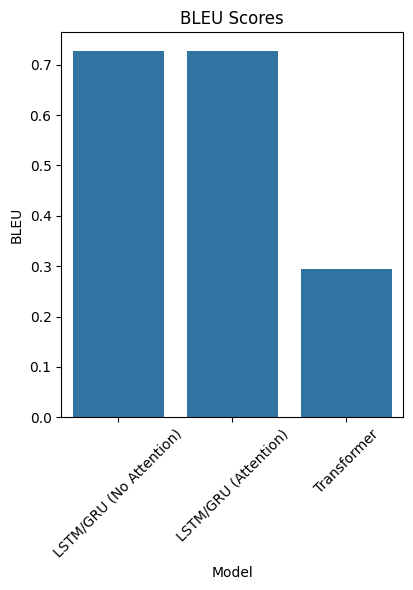

In [ ]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='BLEU', data=results_df)
plt.title('BLEU Scores')
plt.xticks(rotation=45)






([0, 1, 2],
 [Text(0, 0, 'LSTM/GRU (No Attention)'),
  Text(1, 0, 'LSTM/GRU (Attention)'),
  Text(2, 0, 'Transformer')])

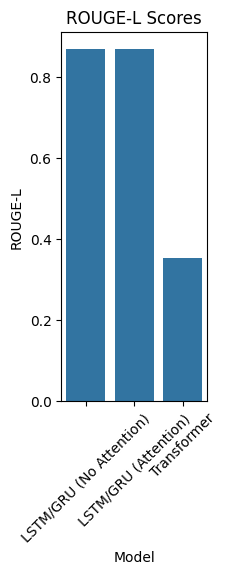

In [ ]:
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='ROUGE-L', data=results_df)
plt.title('ROUGE-L Scores')
plt.xticks(rotation=45)



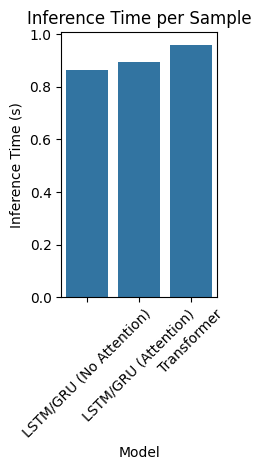

In [ ]:
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='Inference Time (s)', data=results_df)
plt.title('Inference Time per Sample')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()